### Data Cleaning

Ideally: find a manageable sized dataset for book ratings

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("review.csv", on_bad_lines="skip", delimiter=";")
data.columns = ["user_id", "book_isbn", "rating"]

In [2]:
rated = data[data["rating"] != 0]
book_rating_count = {}
user_rating_count = {}

for isbn in rated["book_isbn"]:
    if isbn not in book_rating_count:
        book_rating_count[isbn] = 1
    else:
        book_rating_count[isbn] += 1

for user_id in rated["user_id"]:
    if user_id not in user_rating_count:
        user_rating_count[user_id] = 1
    else:
        user_rating_count[user_id] += 1

In [3]:
# Replace original IDs with numerical user IDs
def create_ids(original, min_num):
    ids = {}
    i = 0
    for k, v in original.items():
        if v >= min_num:
            if k not in ids:
                ids[k] = i
                i += 1
    return ids

In [11]:
# ratings: matrix to record book ratngs, 
# where users as rows and books as columns

MIN_RATINGS_FOR_BOOK = 200
MIN_RATINGS_FOR_USER = 30

book_ids = create_ids(book_rating_count, MIN_RATINGS_FOR_BOOK)
user_ids = create_ids(user_rating_count, MIN_RATINGS_FOR_USER)

ratings = np.zeros([len(user_ids), len(book_ids)])
for _, info in rated.iterrows():
    u = info["user_id"]
    b = info["book_isbn"]
    rate = info["rating"]
    if u in user_ids and b in book_ids:
        i = user_ids[u]
        j = book_ids[b]
        ratings[i, j] = rate

In [12]:
df = pd.DataFrame(ratings)
df.to_csv("ratings_pop.csv")

In [13]:
ratings.shape

(2413, 32)

In [15]:
print("The sparcity of the new incomplete matrix is:")
print((1 - np.count_nonzero(ratings) / np.size(ratings)))

The sparcity of the new incomplete matrix is:
0.9612645047658517


##### SVT

In [14]:
try_matrix = ratings

# set iteration limit k
k = 10
# set threshold for singular values
threshold = 10
# set error tolerance
max_err = 0.05
# value for empty entry
VAC = 0

n, p = try_matrix.shape

for _ in range(k):

    # get SVD of the old matrix and threshold singular values
    u, s, vh = np.linalg.svd(try_matrix)
    print("largest singular value is ", np.max(s))
    s[s < threshold] = 0

    # use remaining singular values build new sigma matrix
    new_sigma = np.zeros([n, p])
    for idx in range(len(s)):
        new_sigma[idx][idx] = s[idx]
    
    # build new matrix
    X_new = u @ new_sigma @ vh

    # recover existing entries
    for i in range(n):
        for j in range(p):
            if try_matrix[i][j] != VAC:
                X_new[i][j] = try_matrix[i][j]

    err = np.linalg.norm(try_matrix - X_new)
    print("Error reduced to ", err)
    if err < max_err:
        break
    else:
        try_matrix = X_new

print("Get an predicted matrix X")

largest singular value is  163.6865411285945
Error reduced to  7.934046101680437e-13
Get an predicted matrix X


### Singular Value Thresholding with Jokes (testing on joke rating dataset)


##### 1. load in dataset

In [1]:
#python
import scipy.io as sio
import numpy as np
import random
import matplotlib.pyplot as plt

# load the data matrix X
d_jest = sio.loadmat('jesterdata.mat') 
X = d_jest['X']
# load known ratings y and true ratings truey
d_new = sio.loadmat('newuser.mat') 
y = d_new['y']
true_y = d_new['truey']
# total number of joke ratings should be m = 100, n = 7200
m, n = X.shape

# train on ratings we know for the new user
train_indices = np.squeeze(y != -99) 
num_train = np.count_nonzero(train_indices)

# test on ratings we don’t know
test_indices = np.logical_not(train_indices) 
num_test = m - num_train
X_data = X[train_indices , 0:20] 
y_data = y[train_indices]
y_test = true_y[test_indices]

print("The training features dataset X_data:", X_data.shape)

The training features dataset X_data: (25, 20)


##### 2. create incomplete data on training dataset

In [2]:
def create_imcomplete_matrix(X, sparsity):
    '''
    X: complete matrix
    sparsity: proportion of empty entries, 0 < sparsity < 1
    '''
    # Make a copy of the original training data
    X_incomplete = X.copy()

    # Randomly create 20% vacancies inside the matrix 
    # (automatically round up to an integer)
    n, p = X_incomplete.shape

    NUM_VAC = int(X_incomplete.size * sparsity)
    VAC = -99
    pokes = 0

    # keep masking random entries in matrix 
    # until there are NUM_VAC empty entries
    while pokes < NUM_VAC:
        i = random.randint(0,n-1)
        j = random.randint(0,p-1)
        if X_incomplete[i,j] != VAC:
            pokes += 1
            X_incomplete[i,j] = VAC

    return X_incomplete


In [3]:
VAC = - 99

def recover_incomplete_matrix(X_incomplete, k=10, threshold=50, max_err=0.5):

    n, p = X_incomplete.shape

    X_guess = np.zeros([n,p])
    for i in range(n):
        for j in range(p):
            if X_incomplete[i][j] != VAC:
                X_guess[i][j] = X_incomplete[i][j]

    errors = np.zeros(k)

    for ik in range(k):

        # get SVD of the old matrix and threshold singular values
        u, s, vh = np.linalg.svd(X_guess)
        s[s < threshold] = 0

        # use remaining singular values build new sigma matrix
        new_sigma = np.zeros([n, p])
        for idx in range(len(s)):
            new_sigma[idx][idx] = s[idx]
        
        # build new matrix
        X_new = u @ new_sigma @ vh
        # recover existing entries
        for i in range(n):
            for j in range(p):
                if X_incomplete[i][j] != VAC:
                    X_new[i][j] = X_incomplete[i][j]
        
        err = np.linalg.norm(X_guess - X_new)
        errors[ik] = err
        # print("Error reduced to ", err)
        if err < max_err:
            break
        else:
            X_guess = X_new

    return X_guess, errors

##### Visualizing errors

In [4]:
import matplotlib.pyplot as plt

k = 20
iterations = [ik for ik in range(k)]

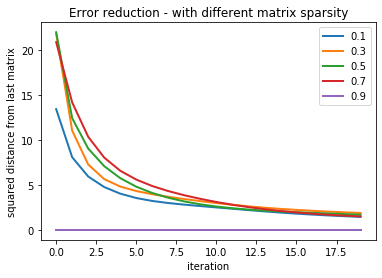

In [20]:
#### Error in relation with sparsity of the matrix

sparce = np.linspace(0.1, 0.9, num=5)
threshold = 20
max_err = 0.05

error_record = []

for sparsity in sparce:
    X = create_imcomplete_matrix(X_data, sparsity)
    _, errors = recover_incomplete_matrix(X, k, threshold, max_err)
    error_record.append(errors)

for i in range(len(sparce)):
    sparsity = sparce[i]
    line = error_record[i]
    plt.plot(iterations, line, label=str(sparsity.round(2)), linewidth =2)
plt.xlabel('iteration')
plt.ylabel('squared distance from last matrix')
plt.title('Error reduction - with different matrix sparsity')
plt.legend()
plt.show()


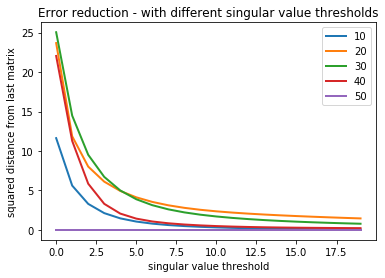

In [22]:
#### Error in relation with sparsity of the singular value threshold

sparsity = 0.5
thresholds = [10, 20, 30, 40, 50]
max_err = 0.05

error_record = []

for t in thresholds:
    X = create_imcomplete_matrix(X_data, sparsity)
    _, errors = recover_incomplete_matrix(X, k, t, max_err)
    error_record.append(errors)

for i in range(len(thresholds)):
    t = thresholds[i]
    line = error_record[i]
    plt.plot(iterations, line, label=str(t), linewidth =2)
plt.xlabel('singular value threshold')
plt.ylabel('squared distance from last matrix')
plt.title('Error reduction - with different singular value thresholds')
plt.legend()
plt.show()


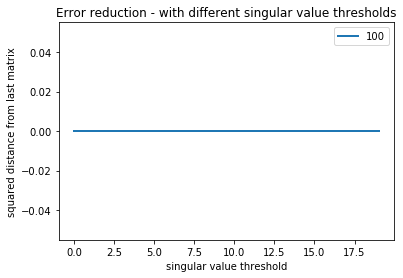

In [28]:
#### Error in relation with sparsity of the singular value threshold

sparsity = 0.99
threshold = 100
max_err = 0.05

error_record = []

X = create_imcomplete_matrix(X_data, sparsity)
_, errors = recover_incomplete_matrix(X, k, t, max_err)

plt.plot(iterations, errors, label=str(threshold), linewidth =2)
plt.xlabel('singular value threshold')
plt.ylabel('squared distance from last matrix')
plt.title('Error reduction - with different singular value thresholds')
plt.legend()
plt.show()
